# Rachunek macierzowy - odwracanie macierzy

**Wykonali: Alicja Niewiadomska, Paweł Kruczkiewicz**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings("ignore")

## Pseudokod rozwiązania

Zakładamy, że dana macierz ma wymiary 2^k x 2^k.

Dane: 
  - `A` - macierz kwadratowe o rozmiarze 2^k
  - `k` - wyżej wspomniany wykładnik
  
Wartość zwracana: 
   `B` - wynikowa macierz kwadratowa o rozmiarze 2^k - odwrotność `A`
```
def inverse(A, k):
    if k == 0: return A

    A11, A12, A21, A22 = split_matrix_in_quatres(A)
    mat_mul = lambda M, N: mat_mul(M, N, k, 1)

    A11_inv = inverse(A11, k-1)
    S22 = A22 - mat_mul(mat_mul(A21, A11_inv), A12)
    S22_inv = inverse(S22, k-1)

    B11 = mat_mul(A11_inv, (I + mat_mul(mat_mul(A12, S22_inv), mat_mul(A21, A11_inv))))
    B12 = - mat_mul(mat_mul(A11_inv, A12), S22_inv)
    B21 = - mat_mul(mat_mul(S22_inv, A21), A11_inv)
    B22 = S22_inv

    return join_matrices(B11, B12, B21, B22)
```

gdzie operacja `mat_mul` definiujemy jak w poprzednim zadaniu:

```
def mat_mul(A, B, k, l):
    if k <= l:
        return binet_rec_mat_mul(A, B, k, l)
    else:
        return strass_mat_mul(A, B, k, l)
```

Optymalną wartością `l` było 4, więc to tę wartość będziemy używać w poniższym kodzie.

## Kod algorytmu

### Funkcje pomocnicze

In [2]:
def split_matrix_in_quatres(A: np.array):
    half_i = A.shape[0] // 2
    return  A[:half_i, :half_i], \
            A[:half_i, half_i:], \
            A[half_i:, :half_i],\
            A[half_i:, half_i:]
            
def join_matrices(A11, A12, A21, A22):
    A1 = np.hstack((A11, A12))
    A2 = np.hstack((A21, A22))
    return np.vstack((A1, A2))

### Algorytm rekurencyjny Bineta

In [3]:
def binet_rec_mat_mul(A: np.array, B: np.array, k: int, l: int) -> np.array:
    if k == 0:
        return A*B
    
    rec_step = lambda A1, B1, A2, B2: mat_mul(A1, B1, k-1, l) + mat_mul(A2, B2, k-1, l)

    A11, A12, A21, A22 = split_matrix_in_quatres(A)
    B11, B12, B21, B22 = split_matrix_in_quatres(B)
    
    C11 = rec_step(A11, B11, A12, B21)
    C12 = rec_step(A11, B12, A12, B22)
    C21 = rec_step(A21, B11, A22, B21)
    C22 = rec_step(A21, B12, A22, B22)
    
    return join_matrices(C11, C12, C21, C22)

### Algorytm rekurencyjny Strassena

In [4]:
def strassen_mat_mul(A: np.array, B: np.array, k: int, l: int) -> np.array:    
    if k == 0:
        return A*B
    
    rec_step = lambda A1, B1: mat_mul(A1, B1, k-1, l)

    A11, A12, A21, A22 = split_matrix_in_quatres(A)
    B11, B12, B21, B22 = split_matrix_in_quatres(B)

    M1 = rec_step(A11 + A22, B11 + B22)
    M2 = rec_step(A21 + A22, B11)
    M3 = rec_step(A11, B12 - B22)
    M4 = rec_step(A22, B21 - B11)
    M5 = rec_step(A11 + A12, B22)
    M6 = rec_step(A21 - A11, B11 + B12)
    M7 = rec_step(A12 - A22, B21 + B22)

    C11 = M1 + M4 - M5 + M7
    C12 = M3 + M5
    C21 = M2 + M4
    C22 = M1 - M2 + M3 + M6
    
    return join_matrices(C11, C12, C21, C22)

### Algorytm mnożenia macierzy z poprzedniego zadania

In [5]:
def mat_mul(A, B, k, l):
    if k <= l:
        return binet_rec_mat_mul(A, B, k, l)
    else:
        return strassen_mat_mul(A, B, k, l)

### Algorytm rekurencyjnego mnożenia macierzy

In [6]:
L = 4

def inverse(A, k):
    if k == 0: 
        return A

    A11, A12, A21, A22 = split_matrix_in_quatres(A)
    mul = lambda M, N: mat_mul(M, N, k-1, L)

    A11_inv = inverse(A11, k-1)
    S22 = A22 - mul(mul(A21, A11_inv), A12)
    S22_inv = inverse(S22, k-1)

    B11 = mul(A11_inv, (np.ones(2**(k-1)) + mul(mul(A12, S22_inv), mul(A21, A11_inv))))
    B12 = - mul(mul(A11_inv, A12), S22_inv)
    B21 = - mul(mul(S22_inv, A21), A11_inv)
    B22 = S22_inv

    return join_matrices(B11, B12, B21, B22)

## Wykresy

In [7]:
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams['font.size'] = 24
plt.style.use('fivethirtyeight')

### Wykres czasu mnożenia od wielkości macierzy `A`

In [8]:
k_values = np.arange(2, 9)
num_range = 100

### kod generujący czas

def measure_inverse_times() -> np.array:
    def measure_one_time(k):
        size = 2**k
        A = np.random.randint(0, num_range, (size, size))
        
        t1 = time.time()
        inverse(A, k)
        t2 = time.time()
        return t2 - t1
    
    return np.array([measure_one_time(k) for k in k_values])

### kod wykresu

def plot_time_results(times: np.array) -> None:
    x = k_values
    x_axis = np.arange(len(x))
    
    plt.bar(x_axis + 0.1, times, 0.1)

    plt.xticks(x_axis, x)
    plt.xlabel("k (matrix size 2^k)")
    plt.ylabel("Time in log scale [s]")
    plt.yscale("log")
    plt.title("Matrix inverse performance")
    plt.show()

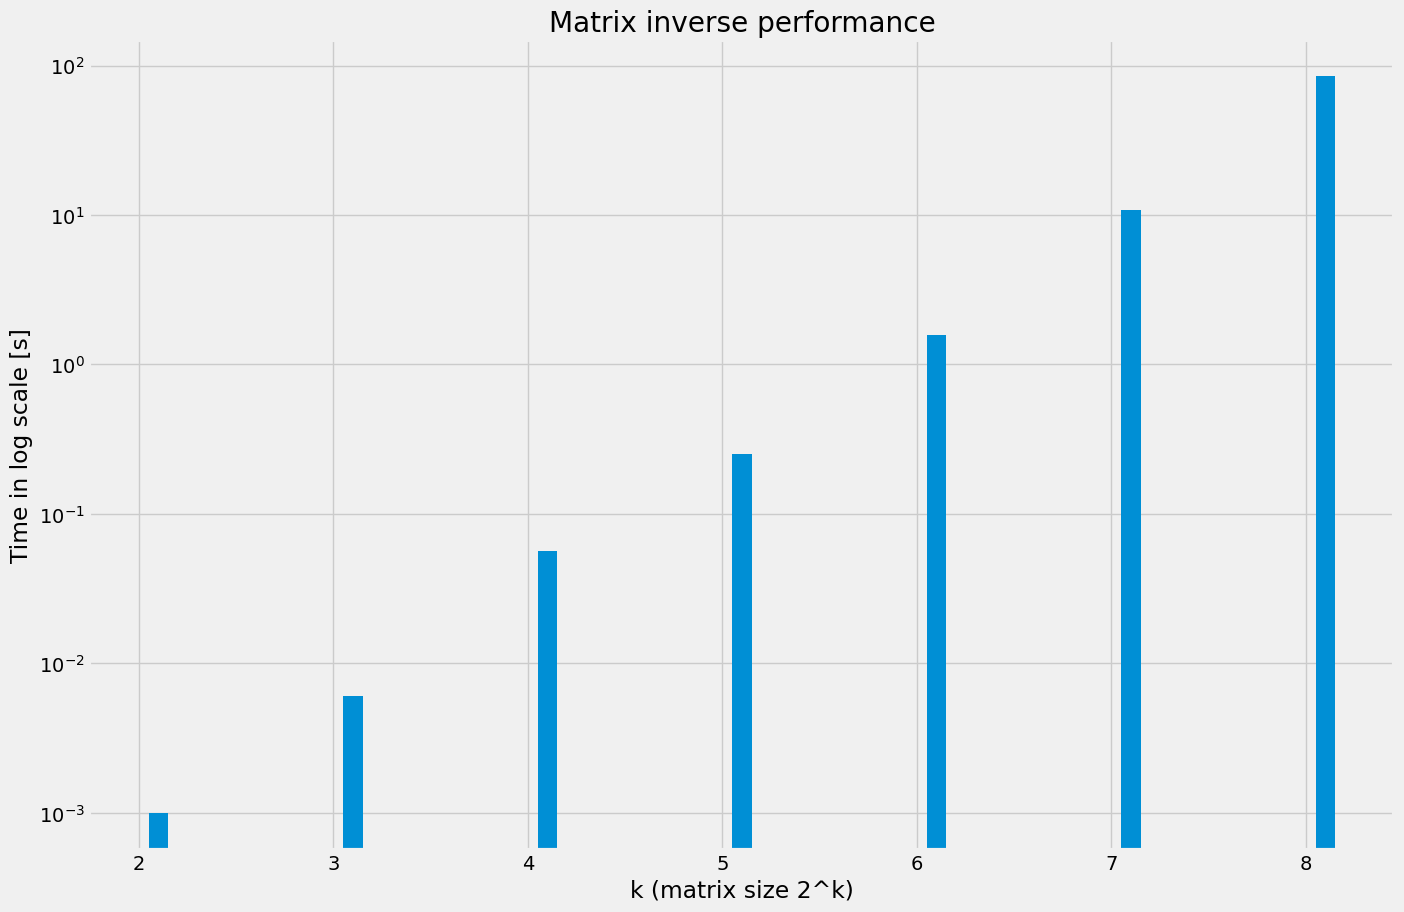

In [9]:
times = measure_inverse_times()
plot_time_results(times.T)

Powyższy wykres jasno pokazuje, że złożoność obliczeniowa stworzonego algorytmu jest odpowiednia.

### Wykres wykonanych obliczeń zmiennoprzecinkowych w zależności od wielkości macierzy `A`

In [10]:
### kod generujący liczbę obliczeń zmiennoprzecinkowych

def binet_rec_mat_mul_op_count(k: int, l: int) -> int:
    if k == 0:
        return 1  # multiplying matrices
    
    n =  2**(k-1)
    rec_step_op_count = 2 * mat_mul_op_count(k-1, l) + n*n
    
    C11_op_count = rec_step_op_count
    C12_op_count = rec_step_op_count
    C21_op_count = rec_step_op_count
    C22_op_count = rec_step_op_count
    
    return C11_op_count + C12_op_count + C21_op_count + C22_op_count
    

def strassen_mat_mul_op_count(k: int, l: int) -> int:
    if k == 0:
        return 1
    
    n = 2**(k-1)
    
    rec_step_op_count = mat_mul_op_count(k-1, l)
    
    M1_op_count = rec_step_op_count + 2*n*n
    M2_op_count = rec_step_op_count + n*n
    M3_op_count = rec_step_op_count + n*n
    M4_op_count = rec_step_op_count + n*n
    M5_op_count = rec_step_op_count + n*n
    M6_op_count = rec_step_op_count + 2*n*n
    M7_op_count = rec_step_op_count + 2*n*n
    
    C11_op_count = 3*n*n
    C12_op_count = n*n
    C21_op_count = n*n
    C22_op_count = 3*n*n
    
    return C11_op_count + C12_op_count + C21_op_count + C22_op_count + M1_op_count + M2_op_count + M3_op_count + M4_op_count + M5_op_count + M6_op_count + M7_op_count


In [11]:
def mat_mul_op_count(k: int, l: int) -> int:
    if k <= l: 
        return binet_rec_mat_mul_op_count(k, l)
    else: 
        return strassen_mat_mul_op_count(k, l)



In [12]:
def inverse_op_count(k: int) -> int:
    if k == 0:
        return 0
    
    n = 2**(k-1)
    
    A11_inv_rec_step = inverse_op_count(k-1)
    S22_count = n*n + 2*mat_mul_op_count(k-1, L)
    S22_inv_rec_step = inverse_op_count(k-1)
    
    B11_count = n*n + 4*mat_mul_op_count(k-1, L)
    B12_count = 2*mat_mul_op_count(k-1, L)
    B21_count = 2*mat_mul_op_count(k-1, L)
    
    return A11_inv_rec_step + S22_count + S22_inv_rec_step + B11_count + B12_count + B21_count

In [13]:
k_values = range(2, 16)
inverse_ops = np.array([inverse_op_count(k) for k in k_values])

def plot_ops_results(ops: np.array) -> None:    
    x = k_values
    x_axis = np.arange(len(x))
    
    plt.bar(x_axis, ops, 0.2)

    plt.xticks(x_axis, x)
    plt.xlabel("k (matrix size 2^k)")
    plt.ylabel("Number of operations in log scale")
    plt.yscale("log")
    plt.title("Number of floating point operations")
    plt.show()

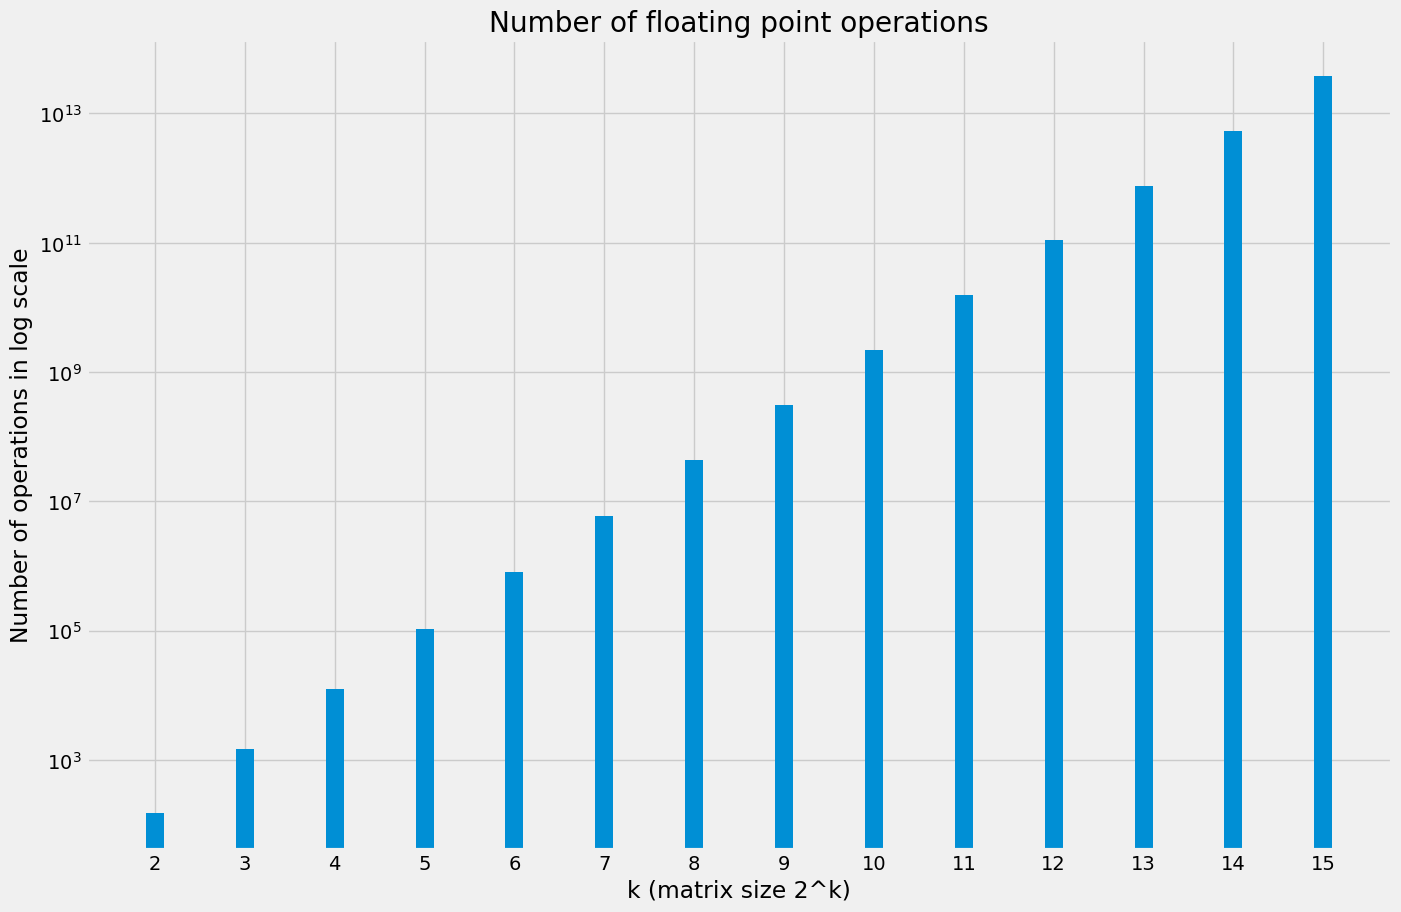

In [14]:
plot_ops_results(inverse_ops.T)

Na powyższym wykresie widzimy, że zależność liczby operacji zmiennoprzecinkowych od rozmiaru macierzy jest wielomianowa.

## Wnioski

W powyższym raporcie pokazano, że zarówno czas jak i liczba operacji zmiennoprzecinkowych zależy wielomianowo od rozmiaru macierzy. 

Badania można rozszerzyć o mądrzejsze używanie pamięci, co potencjalnie pokazałoby korzyści z używania rekurencyjnego odwracania macierzy. Niestety, jest to trudne do osiągnięcia w wybranym języku programowania.